<a href="https://colab.research.google.com/github/traitortots/will-it-ADU/blob/main/Calculating_Setbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs, Imports

In [1]:
pip install geopandas turfpy thefuzz[speedup] rtree folium matplotlib mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 63.5 MB/s eta 0:00:00
  Created wheel for turfpy: filename=turfpy-0.0.7-py3-none-any.whl size=39108 sha256=9c3b8e7f7e4eb48bfeab4211b980c98d4121c80c78bcbba838fed7489f65b5cc
  Stored in directory: /root/.cache/pip/wheels/7a/05/e3/11a72686a770c2117b4465d02abd5f25f8d94c2f823ca0c112
Successfully built turfpy


In [2]:
pip install pyturf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyturf: filename=pyturf-0.6.3-py3-none-any.whl size=55954 sha256=323a8bddd4b3e693c3db3dbbafb91fec4c20c6c544129e58a11bb3fea8ee55e5
  Stored in directory: /root/.cache/pip/wheels/7f/cc/61/7d1be5636a7414c0184bb9161d060992914b0a67bca76c4316
Successfully built pyturf


In [59]:
from shapely.geometry import Polygon, LineString, MultiLineString, Point, MultiPoint, MultiPolygon
from shapely.geometry.base import BaseGeometry
from shapely.strtree import STRtree
from shapely.ops import linemerge, unary_union, nearest_points
from shapely.affinity import translate, rotate
import math
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
import pyproj
import numpy as np
from thefuzz import fuzz
from typing import List, Tuple
import traceback
from typing import List, Union, Optional, Tuple, Any

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)

# Data Prep

In [5]:
# Load the geojson file into a GeoDataFrame
parcels_gdf = gpd.read_file("/content/drive/MyDrive/Cornell/Exit Project/Parcels_Public.geojson")

# Reproject the GeoDataFrame to EPSG:2906 in place
parcels_gdf = parcels_gdf.to_crs(epsg=2906)

parcels_gdf['throughlot'] = False
parcels_gdf['hasinteriorside'] = False
parcels_gdf['hasstreetside'] = False


# Set the unique ID of the parcel you want to extract
parcel_id = 3641

# Get the polygon for the specified parcel ID
parcel_poly = parcels_gdf.loc[parcels_gdf['FID'] == parcel_id, 'geometry'].iloc[0]

In [6]:
parcels_gdf.crs

<Projected CRS: EPSG:2906>
Name: NAD83(HARN) / New York Central (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Broome; Cayuga; Chemung; Chenango; Cortland; Jefferson; Lewis; Madison; Oneida; Onondaga; Ontario; Oswego; Schuyler; Seneca; Steuben; Tioga; Tompkins; Wayne; Yates.
- bounds: (-77.75, 41.99, -75.06, 44.41)
Coordinate Operation:
- name: SPCS83 New York Central zone (US Survey feet)
- method: Transverse Mercator
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
roads_gdf = gpd.read_file("/content/drive/MyDrive/Cornell/Exit Project/TcStreets.geojson")

In [8]:
roads_gdf.head()

,FID,ET_ID,FullStreet,CityNameL,CityNameR,Maintenanc,STNAMEID,LengthFT,LengthMi,CNL_IS_CLR,CITYNAMES,Shape__Length,geometry
0,1,501,DAVIS RD,T LANSING,T LANSING,Town,1521,22871.383510,4.331701,1,T LANSING,9477.432423,"LINESTRING (-76.54938 42.57381, -76.55214 42.5..."
1,2,502,DAWES HILL RD,T DANBY,T DANBY,Town,1522,5846.722813,1.107334,1,T DANBY,2413.069586,"LINESTRING (-76.53665 42.29915, -76.53366 42.2..."
2,3,503,DEARBORN PL,C ITHACA,C ITHACA,City of Ithaca,1523,840.298784,0.159147,1,C ITHACA,346.949516,"LINESTRING (-76.48395 42.45528, -76.48365 42.4..."
3,4,504,DECAMP RD,T LANSING,T LANSING,Town,1524,7119.706659,1.348429,1,T LANSING,2944.116450,"LINESTRING (-76.49726 42.61137, -76.49797 42.6..."
4,5,505,DECANN DR,T ENFIELD,T ENFIELD,Tompkins County,1525,648.269329,0.122778,1,T ENFIELD,267.496711,"LINESTRING (-76.61188 42.46033, -76.61173 42.4..."


# Global Variables

In [9]:
_maxRowWidth = int(250)

In [10]:
_tolerance = 0.1  # You can adjust this global variable to control the cleanup tolerance

In [11]:
# Identify the CRS used by your GeoDataFrame
source_crs = parcels_gdf.crs

# Functions

In [12]:
def lotlines(FID: int, geometry: Polygon) -> Union[bool, Any]:
    # Get lot lines for the given parcel (geometry) by calling the `getlotlines()` function
    lines = getlotlines(geometry)
    print(lines)

    try:
        # Get the maximum row width, which is used to determine front lot lines
        max_row_width = _maxRowWidth

        # Get neighboring parcels for the given parcel (geometry) by calling the `getNeighboringParcels()` function
        np = getNeighboringParcels(geometry, parcels_gdf, FID)

        print("np value: ", np)

        # Get street side information for the parcel by calling the `getStreetSides()` function
        streetside_info = getStreetSides(lines, np)
        streetside = streetside_info[0]  # list containing street-facing lot line info (boolean values)
        shortest_index = streetside_info[1]  # index of the shortest street-facing lot line

        new_np = []  # list to store non-ROW neighboring parcels
        bad_np = []  # list to store ROW neighboring parcels

        # Check if there are no street-facing lot lines (all values in `streetside` are False)
        if all(not l[0] and not l[1] for l in streetside):
            # Iterate through neighboring parcels to remove ROW parcels
            for i in range(len(np)):
                neighboring_parcel_geometry = np.iloc[i]['geometry']
                neighboring_parcel_FID = np.iloc[i]['FID']

                # If the neighboring parcel has fewer than 10 neighbors, consider it as non-ROW
                if len(getNeighboringParcels(neighboring_parcel_geometry, parcels_gdf, neighboring_parcel_FID)) < 10:
                    new_np.append(np.iloc[i])
                else:
                    bad_np.append(np.iloc[i])  # Add ROW parcel to bad_np list

            # Update street side information after removing ROW parcels
            streetside_info = getStreetSides(lines, new_np)
            streetside = streetside_info[0]
            # If there are still no street-facing lot lines, set the lot lines value to False
            if all(not l[0] and not l[1] for l in streetside):
                return False
            shortest_index = streetside_info[1]

        # Get front information for the parcel by calling the `getFrontInfo()` function
        front_info = getFrontInfo(FID, geometry, lines, streetside, shortest_index, max_row_width, bad_np)

        # Update the lot lines information for the given parcel (FID) by calling the `getLotInfo()` function
        lot_info = get_lot_info(lines, front_info[0], front_info[2], front_info[1], FID)

    # If an exception occurs during the lot lines calculation, print the exception message, traceback, and set the lot lines value to False
    except Exception as e:
        print(f"Error occurred while calculating lot lines for FID {FID}: {e}")
        print("Traceback:")
        print(traceback.format_exc())
        lot_info = False

    # Attempt to correct the front and side lot lines if the parcel is a flag lot by calling the `fixFlagLot()` function
    try:
        fix_flag_lot(lot_lines, geometry, FID)
    except Exception as e:
        pass

    # Return the calculated lot lines for the given parcel (FID)
    return lot_info

In [80]:
def getlotlines(lot: Polygon, bearing: Optional[List[float]] = None) -> Union[bool, List[LineString]]:
    # Calculate the convex hull of the input lot using Shapely's convex_hull function
    parcel = lot.convex_hull
    print("Parcel convex hull: ", parcel)

    # Use the explodeLine function to get line segments for the convex hull
    parcel_line = explodeLine(parcel)
    print("Parcel convex hull lines: ", parcel_line)

    # Calculate rhumb bearings for each line segment
    parcel_bearing = [calculate_rhumb_bearing(list(line.coords[0]), list(line.coords[1])) for line in parcel_line]
    print("Parcel bearings: ", parcel_bearing)

    # Calculate the minimum rotated rectangle for the lot using Shapely's minimum_rotated_rectangle function
    min_rotated_rect = lot.minimum_rotated_rectangle
    print("Parcel min rect: ", min_rotated_rect)

    # Use the explodeLine function to get line segments for the minimum rotated rectangle
    bbox_line = explodeLine(min_rotated_rect)
    print("Parcel bbox lines: ", bbox_line)

    # Calculate rhumb bearings for the bounding box line segments
    if bearing is None:
        bbox_bearing = [calculate_rhumb_bearing(list(line.coords[0]), list(line.coords[1])) for line in bbox_line]
    else:
        bbox_bearing = bearing

    # Assign bearings to the bounding box bearings
    assignment = [assignbearing(parcel_bearing_item, bbox_bearing) for parcel_bearing_item in parcel_bearing]
    print("bbox bearing assignment: ", assignment)

    # Special case when the convex hull is 4-sided
    if len(parcel_line) <= 3:
        print("Convex hull has 3 or fewer sides:", parcel_line)
        return False

    # Simplify the parcel polygon
    parcel = parcel.simplify(0.000001, preserve_topology=True)
    print("Simplified parcel hull: ", parcel)

    # Perform cleanup of the simplified polygon
    geom = cleanupgon(parcel, 2) # dupe of shapely's simplify?
    # geom = parcel  # Use the simplified parcel directly
    print("cleanupgon'd parcel hull: ", geom)

    parcel = geom

    parcel_line = explodeLine(parcel)
    print("Parcel convex hull lines: ", parcel_line)

    parcel_bearing = [calculate_rhumb_bearing(list(line.coords[0]), list(line.coords[1])) for line in parcel_line]
    print("Parcel convex hull: ", parcel_bearing)

    min_rotated_rect = lot.minimum_rotated_rectangle
    print("Original Parcel min rect: ", min_rotated_rect)

    orig_bbox_line = explodeLine(min_rotated_rect)
    print("Original Parcel min rect lines: ", bbox_line)

    if bearing is None:
        orig_bbox_bearing = [calculate_rhumb_bearing(list(line.coords[0]), list(line.coords[1])) for line in orig_bbox_line][:2]
    else:
        orig_bbox_bearing = bearing
    print("Orig parcel min rect bearings: ", orig_bbox_bearing)

    # Assign bearings based on the cleaned-up polygon
    assignment = [assignbearing(parcel_bearing_item, orig_bbox_bearing) for parcel_bearing_item in parcel_bearing]
    print("Parcel convex hull: ", assignment)

    # Extract the lines and concavify them
    result = []
    extracted_lines = extract_lines(parcel_line, assignment)
    print("Extracted lines: ", extracted_lines)
    for line_group in extracted_lines:
        for line in line_group:
            concavified_line = concavify(line, lot)
            result.append(concavified_line)
    print("getlotlines Result:", result)
    return result

In [14]:
# adapted from https://gis.stackexchange.com/questions/436679/how-to-convert-polygons-to-line-segments-using-python
def explodeLine(poly: Polygon) -> List[LineString]:
    """A function to return all segments of a line as a list of linestrings"""
    coords = poly.exterior.coords #Create a list of all line node coordinates
    parts = []
    for part in zip(coords, coords[1:]): #For each start and end coordinate pair
        parts.append(LineString(part)) #Create a linestring and append to parts list
    return parts

In [73]:
# Function to calculate rhumb bearing between two points

Coordinate = Union[Tuple[float, float], List[float]]

def calculate_rhumb_bearing(
    pt1: Coordinate, 
    pt2: Coordinate, 
    source_crs: Union[str, pyproj.CRS] = source_crs
) -> float:
    geod = pyproj.Geod(ellps="WGS84")

    # Create a transformer to convert from the source CRS to EPSG:4326
    transformer = Transformer.from_crs(source_crs, "EPSG:4326")

    # Transform the coordinates to latitude and longitude
    lon1, lat1 = transformer.transform(pt1[1], pt1[0])
    lon2, lat2 = transformer.transform(pt2[1], pt2[0])

    angle, reverse_angle, distance = geod.inv(lon1, lat1, lon2, lat2)

    # Normalize the angle to the range -180 to 180
    bearing = (angle + 180) % 360 - 180
    return bearing


In [50]:
def rhumb_bearings_from_linestring(
    linestring: LineString, 
    source_crs: Union[str, pyproj.CRS] = "EPSG:4326"
) -> List[float]:
    bearings = []
    for i in range(len(linestring.coords) - 1):
        pt1 = linestring.coords[i]
        pt2 = linestring.coords[i + 1]
        bearing = calculate_rhumb_bearing(pt1, pt2, source_crs)
        bearings.append(bearing)
    return bearings


In [51]:
def assignbearing(bearing: float, reference: List[float]) -> int:
    m1 = min(abs(reference[0] - bearing), (180 - reference[0]) + bearing if bearing <= reference[0] else (180 - bearing) + reference[0])
    m2 = min(abs(reference[1] - bearing), (180 - reference[1]) + bearing if bearing <= reference[1] else (180 - bearing) + reference[1])
    return 0 if m1 <= m2 else 1

In [53]:
def concavify(line: LineString, lot: Polygon) -> LineString:
    start = line.coords[0]
    end = line.coords[-1]

    lot_coords = list(lot.exterior.coords)[:-1]
    double_lot_coords = lot_coords + lot_coords

    l1, l2 = [], []

    i = 0
    while i < len(double_lot_coords) and double_lot_coords[i] != start:
        i += 1
    while i < len(double_lot_coords) and double_lot_coords[i] != end:
        l1.append(double_lot_coords[i])
        i += 1
    l1.append(double_lot_coords[i])

    i = 0
    while i < len(double_lot_coords) and double_lot_coords[i] != end:
        i += 1
    while i < len(double_lot_coords) and double_lot_coords[i] != start:
        l2.append(double_lot_coords[i])
        i += 1
    l2.append(double_lot_coords[i])

    l1 = LineString(l1)
    l2 = LineString(l2)

    return l1 if l1.length <= l2.length else l2

In [35]:
def extract_lines(parcel_line: List[LineString], assignment: List[int]) -> List[List[LineString]]:
    # If all assignments are 0 or all assignments are 1, return an empty list
    if all(a == 0 for a in assignment) or all(a == 1 for a in assignment):
        return []

    # Rotate parcel_line and assignment so that the first and last assignments differ
    while assignment[0] == assignment[-1]:
        parcel_line = [parcel_line[-1]] + parcel_line[:-1]
        assignment = [assignment[-1]] + assignment[:-1]

    # Count the number of changes in assignment values along the polygon boundary
    value_changes = 0
    for i in range(1, len(assignment)):
        if assignment[i] != assignment[i - 1]:
            value_changes += 1

    # If there are less than 3 changes, return an empty list
    if value_changes < 3:
        return []

    # Duplicate parcel_line and assignment to avoid boundary issues when looping
    double_line = parcel_line + parcel_line
    double_assignment = assignment + assignment
    lotline = [[], []]  # Initialize lotline as a list containing two empty lists

    # Loop for two cases: assignment value 0 and assignment value 1
    for case in range(2):
        # Loop twice to extract two continuous line segments for each case
        for _ in range(2):
            # Find the first index with the current case value
            i = 0
            while i < len(double_assignment) and double_assignment[i] != case:
                i += 1

            # Collect line segments with the current case value
            line = []
            while i < len(double_assignment) and double_assignment[i] == case:
                line.append(double_line[i])
                i += 1

            # Convert line to a LineString object with coordinates from start to end
            line = [segment.coords[0] for segment in line] + [line[-1].coords[-1]]
            lotline[case].append(LineString(line))

    # Return the extracted line segments as a list of two groups (for assignment values 0 and 1)
    return lotline

In [68]:
''' 
This function assumes that the CRS (coordinate reference system) of your input geometry and the parcels_gdf are in a 
projected CRS with units in feet. If your data is in a different CRS or uses different units, you may need to adjust 
the buffer_distance accordingly.
'''
def getNeighboringParcels(geometry: BaseGeometry, parcels_gdf: GeoDataFrame, FID: int, buffer_distance: Optional[float] = 1) -> GeoDataFrame:
    # Buffer the input geometry by 1 foot
    buff_geom = geometry.buffer(buffer_distance)

    # Check if the input geometry is a polygon
    is_poly = isinstance(geometry, Polygon)

    # Filter parcels_gdf to only include parcels that have a different FID and intersect with buff_geom
    neighboring_parcels = parcels_gdf[(parcels_gdf['FID'] != FID) & (parcels_gdf['geometry'].intersects(buff_geom))]
    print(f"Number of Neighboring Parcels (before filtering): {len(neighboring_parcels)}")

    if is_poly:
        try:
            # Calculate a representative point for the input geometry
            pt = geometry.representative_point()

            # Filter neighboring_parcels to only include parcels that do not contain the representative point
            neighboring_parcels = neighboring_parcels[~neighboring_parcels['geometry'].contains(pt)]
        except Exception as e:
            print("Parcel filtering issue: neighborhood search")
    
    print(f"Number of Neighboring Parcels (after filtering): {len(neighboring_parcels)}")
    return GeoDataFrame(neighboring_parcels)

In [69]:
def getStreetSides(lines: Union[bool, List[LineString]], np: Union[List[Polygon], List[MultiPolygon], GeoDataFrame]) -> Tuple[List[List[bool]], int]:
    # Define a function to create a thin buffer around a LineString geometry
    def thinlinebuffer(line):
        return line.buffer(1)  # Buffer by 1 foot directly, since the data is in a projected coordinate system with feet as the unit

    # Define a function to get the uncovered section of a lot line that is not covered by parcels in np
    def uncovered(line):
        buffered_np = [parcel.buffer(1) for parcel in np]  # Buffer all parcels in np by 1 foot
        buffered_union = MultiPolygon(buffered_np).unary_union  # Get the union of buffered parcels
        return line.difference(buffered_union)  # Return the uncovered section of the lot line

    streetside = []
    shortest_index = -1  # Track the shortest candidate as fallback
    # Get street-facing lot lines
    for i in range(2):
        streetside.append([True, True])
        for j in range(2):
            if len(np) > 0:
                uncovered_area = uncovered(lines[i][j])
                buffer = thinlinebuffer(lines[i][j])

                # Check if the ratio of uncovered area to buffer area is less than 0.15 and the uncovered area is <= 10 sq. ft
                if uncovered_area.is_empty or (uncovered_area.area / buffer.area < 0.15 and uncovered_area.area <= 10):
                    streetside[i][j] = False

            if streetside[i][j] and (shortest_index == -1 or lines[i][j].length < lines[shortest_index // 2][shortest_index % 2].length):
                shortest_index = i * 2 + j

    return (streetside, shortest_index)

In [22]:
def getFrontInfo(FID, geometry, lines, streetside, shortest_index, max_row_width, bad_np):
    address = parcels_gdf.loc[parcels_gdf['FID'] == FID, 'ADDRESS'].values[0].lower().split(',')[0]
    address = address[address.index(' '):].replace(' ', '') # remove address number
    center = geometry.centroid

    # Buffer the parcel geometry using Shapely's buffer function
    buff_lot = geometry.buffer(max_row_width + np.sqrt(geometry.area) / 5280) # convert from feet to degrees

    # Get streets intersecting the buffered lot geometry and sort by similarity to the address
    street_list = sorted([(s, fuzz.token_set_ratio(address, s[1].lower().replace(" ", ""))) for s in get_streets(buff_lot)], key=lambda x: x[1], reverse=True)

    # If no streets are found, return the shortest street-facing lot line
    if not street_list:
        return [-1, None, streetside]

    # Determine front street
    front_street = None
    if street_list[0][1] > 0.5:
        if len(street_list) > 1 and street_list[1][1] > 0.5 and street_list[0][1] == street_list[1][1] and center.distance(street_list[1][0][-1]) < center.distance(street_list[0][0][-1]):
            front_street = street_list[1][0]
        else:
            front_street = street_list[0][0]

    # (1) Draw lines from lot center through candidate lot lines to see if any face the front street
    extrapolated_lines_info = getInfoFromExtrapolatedLines(lines, front_street, center, streetside, street_list, bad_np)
    candidate_lines, street_facing, extrapolated_lines = extrapolated_lines_info

    # (0) Return shortest street-facing lot line if no front street is found
    if not front_street:
        return [shortest_index, None, street_facing]

    # If front road cuts through parcel
    if front_street[-1].intersection(geometry).length > 1:
        return [-1, None, street_facing]

    # (2) Extend and buffer the front street and see if the extrapolated lines intersect
    if not candidate_lines:
        extension = extrapolated_lines_info[3] * 0.75
        buff_extended_st = extend_street(nearest_points(front_street[-1], center)[0], front_street[-1], extension)

        for i in range(2):
            for j in range(2):
                if streetside[i][j] and extrapolated_lines[i][j].intersects(buff_extended_st):
                    candidate_lines.append(i * 2 + j)

    # If no candidates have been found in (1) or (2), assign each street side as a candidate
    if not candidate_lines:
        for i in range(2):
            for j in range(2):
                if streetside[i][j]:
                    candidate_lines.append(i * 2 + j)

    # (3) If there are multiple candidates remaining, sort them by their mean distance to the front street
    if len(candidate_lines) > 1:
        candidate_lines = sort_by_front_st_dist(candidate_lines, lines, front_street)

    # Return only candidate (if sufficiently narrowed by (1) or (2)) or the candidate that is closest to the front street
    return [candidate_lines[0], front_street, street_facing]

In [23]:
def get_streets(geometry):
    # Filter roads_gdf for streets that intersect the input geometry
    intersecting_streets = roads_gdf[roads_gdf.intersects(geometry)]

    # Initialize an empty list for the output
    output_streets = []

    # Iterate through the intersecting streets and format the street names
    for _, row in intersecting_streets.iterrows():
        street_name = row['FullStreet'].upper()
        street_name_parts = street_name.split()
        
        if len(street_name_parts) > 2 and street_name_parts[0] in ["NORTH", "SOUTH", "EAST", "WEST"]:
            street_name_parts.pop(0)
        
        street_name_joined = ' '.join(street_name_parts)
        street_geom = row['geometry']
        
        output_streets.append((street_name_parts, street_name_joined, street_geom))

    return output_streets

In [24]:
def getInfoFromExtrapolatedLines(lines, front_street, center, streetside, street_list, bad_np):
    extrapolated_lines = []
    candidate_lines = []
    street_facing = []
    longest_candidate = 0

    # Helper function to calculate the rhumb destination given center, distance, and bearing
    def rhumb_destination(center, distance, bearing):
        R = 6371008.8 # Earth radius in meters
        d = distance / R  # angular distance in radians
        lat1 = math.radians(center.y)
        lon1 = math.radians(center.x)
        bearing = math.radians(bearing)

        lat2 = math.asin(math.sin(lat1) * math.cos(d) + math.cos(lat1) * math.sin(d) * math.cos(bearing))
        lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(d) * math.cos(lat1), math.cos(d) - math.sin(lat1) * math.sin(lat2))
        lat2 = math.degrees(lat2)
        lon2 = math.degrees(lon2)

        return Point(lon2, lat2)

    # Loop through streetside array
    for i in range(2):
        street_facing.append([False, False])
        extrapolated_lines.append([None, None])

        for j in range(2):
            # Check if the streetside is True for the current index
            if streetside[i][j]:
                curr_line = lines[i][j]
                line_coords = list(curr_line.coords)
                # Calculate the midpoint of the current line
                mid_point = curr_line.interpolate(0.5, normalized=True)
                # Calculate the bearing between center and midpoint
                # Calculate the bearing between center and midpoint
                bearing = calculate_rhumb_bearing((center.x, center.y), (mid_point.x, mid_point.y))
                # Calculate the distance between center and midpoint, and add max_row_width
                distance = center.distance(mid_point) + max_row_width

                # Calculate the extrapolated destination using rhumb_destination function
                extrapolated_destination = rhumb_destination(center, distance, bearing)
                # Create a LineString from center to extrapolated_destination
                extrapolated_line = LineString([center, extrapolated_destination])
                extrapolated_lines[i][j] = extrapolated_line

                # You will need to implement nearestStreets and nearestParcels functions
                near_street = nearest_streets(mid_point, extrapolated_line, street_list)
                near_parcel = nearest_parcels(mid_point, extrapolated_line, bad_np)

                # Check if front street and nearest street are found
                if front_street and near_street[-1] != float("inf"):
                    # Check if front street and nearest street are identical
                    if front_street[-1].equals(near_street[-2]):
                        candidate_lines.append(i * 2 + j)
                    # Check if extrapolated line intersects a street before it intersects a parcel
                    if near_parcel and near_street[-1] < near_parcel[-1]:
                        street_facing[i][j] = True

                # Update the longest_candidate if the current line is longer
                if curr_line.length > longest_candidate:
                    longest_candidate = curr_line.length

    # Return candidate lines, street-facing status, extrapolated lines, and the longest candidate
    return candidate_lines, street_facing, extrapolated_lines, longest_candidate

In [25]:
def nearest_streets(point, line, streets):
    min_distances = []
    
    # Loop through each street in the input streets list
    for street in streets:
        street_geom = street[-1] # Get the geometry of the street (last element in the tuple)
        
        # Calculate the intersection between the street and the input line
        intersection = street_geom.intersection(line)
        
        # If there's no intersection, set the minimum distance to infinity
        if intersection.is_empty:
            min_distance = np.inf
        else:
            # If the intersection is a single point, create a list with just this point
            if intersection.geom_type == 'Point':
                intersection_points = [intersection]
            else: # 'MultiPoint' case, convert the MultiPoint to a list of Points
                intersection_points = list(intersection)
            
            # Calculate the distances between the input point and intersection points,
            # and find the smallest distance (converting from degrees to feet)
            min_distance = min(point.distance(pt) for pt in intersection_points) * 364567.2

        # Add the smallest distance for the current street to the list of minimum distances
        min_distances.append(min_distance)
    
    # Combine the streets and minimum distances, and sort them based on the minimum distance
    sorted_streets = sorted(zip(streets, min_distances), key=lambda x: x[1])
    
    # Return the first street in the sorted list (the nearest street that intersects the input line)
    return sorted_streets[0][0]

In [26]:
def nearest_parcels(point, line, bad_np):
    # Get parcels that intersect the input line
    intersecting_parcels = parcels_gdf[parcels_gdf.intersects(line)]

    # If there are no parcels, return [None, float("inf")]
    if intersecting_parcels.empty:
        return [None, float("inf")]

    # Filter out bad parcels
    filtered_parcels = intersecting_parcels[~intersecting_parcels["geometry"].isin(bad_np)]

    # Calculate the minimum distance from the point to the intersection between the parcel and the input line
    parcel_distances = []
    for _, parcel in filtered_parcels.iterrows():
        intersections = line.intersection(parcel["geometry"])
        distances = [point.distance(pt) for pt in intersections]
        min_distance = min(distances) if distances else float("inf")
        parcel_distances.append((parcel, min_distance))

    # Sort parcels by minimum distance
    parcel_distances.sort(key=lambda x: x[1])

    # Return the nearest parcel and its distance
    return parcel_distances[0]

In [27]:
def extend_street(near_street_pt, front_street, extension):
    # Buffer the near_street_pt
    buff_near_street_pt = near_street_pt.buffer(1)  # 1 foot buffer, no need to convert

    # Find intersection points between the buffer and the front_street
    intersection_pts = front_street.intersection(buff_near_street_pt)

    if isinstance(intersection_pts, Point):
        intersection_pts = [intersection_pts]
    elif isinstance(intersection_pts, MultiPoint):
        intersection_pts = list(intersection_pts)

    # Get the reference point for rotation
    ref_pt = nearest_points(front_street, near_street_pt)[0]

    # Calculate the street angle
    dx = intersection_pts[0].x - ref_pt.x
    dy = intersection_pts[0].y - ref_pt.y
    street_angle = math.degrees(math.atan2(dy, dx))

    # Extend the street on both ends
    extended_start = translate(front_street.coords[0], xoff=-extension*math.cos(math.radians(street_angle)), yoff=-extension*math.sin(math.radians(street_angle)))
    extended_end = translate(front_street.coords[-1], xoff=extension*math.cos(math.radians(street_angle)), yoff=extension*math.sin(math.radians(street_angle)))

    # Create the extended street
    extended_street = LineString([extended_start, *front_street.coords, extended_end])

    # Buffer the extended street
    buff_extended_street = extended_street.buffer(5)  # 5 feet buffer, no need to convert

    return buff_extended_street

In [28]:
def sort_by_front_st_dist(candidates, lines, front_street):
    front_street_geom = front_street[-1]

    # Calculate mean distances for each candidate line segment
    mean_distances = [
        np.mean([nearest_points(point, front_street_geom)[1].distance(point) for point in lines[(idx - idx % 2) // 2][idx % 2].coords])
        for idx in candidates
    ]

    # Sort candidates based on mean distances
    sorted_candidates = [x for _, x in sorted(zip(mean_distances, candidates), key=lambda pair: pair[0])]

    return sorted_candidates

In [29]:
def get_lot_info(lines, frontindex, street_facing, front_street, FID):
    # If frontindex is -1, return False
    if frontindex == -1:
        return False

    # Determine the indices i and j from frontindex
    j = frontindex % 2
    i = (frontindex - j) // 2

    # Identify the front and rear lot lines using the indices i and j
    front = lines[i][j]
    rear = lines[i][1 - j]
    
    # Initialize empty lists for side and streetside lot lines
    side = []
    streetside = []

    # If the rear lot line is street-facing, update the 'throughlot' attribute for the parcel in parcels_gdf
    if street_facing[i][1 - j]:
        parcels_gdf.loc[parcels_gdf['FID'] == FID, 'throughlot'] = True

    # Iterate through the remaining lot lines
    for j in range(2):
        # If the lot line is street-facing, append it to the streetside list
        if street_facing[1 - i][j]:
            streetside.append(lines[1 - i][j])
        # If the lot line is not street-facing, append it to the side list
        else:
            side.append(lines[1 - i][j])

    # If there are interior side lot lines, update the 'hasinteriorside' attribute for the parcel in parcels_gdf
    if side:
        parcels_gdf.loc[parcels_gdf['FID'] == FID, 'hasinteriorside'] = True

    # If there are street side lot lines, update the 'hasstreetside' attribute for the parcel in parcels_gdf
    if streetside:
        parcels_gdf.loc[parcels_gdf['FID'] == FID, 'hasstreetside'] = True

    # If a front street is provided, you can add any necessary processing related to front_street here
    if front_street:
        # Add any necessary processing related to front_street here
        pass

    # Sort the side and streetside lot lines by length
    side.sort(key=lambda x: x.length)
    streetside.sort(key=lambda x: x.length)

    # Return the lot information as a dictionary
    return {'front': front, 'rear': rear, 'side': side, 'streetside': streetside}


In [30]:
def fix_flag_lot(lot_lines, geometry, FID):
    if FID in lot_lines:
        all_sides = sorted(lot_lines[FID]['side'] + lot_lines[FID]['streetside'], key=lambda x: x.length)
        lot_side_len = len(lot_lines[FID]['side'])
        track_longest = lot_side_len > 0 and lot_lines[FID]['side'][-1] == all_sides[1]

        front_and_short_side = all_sides[0].length + lot_lines[FID]['front'].length
        convex_geom = geometry.convex_hull

        if (
            all_sides[1].length >= front_and_short_side
            and convex_geom.area / geometry.area >= 1.2
            and lot_lines[FID]['rear'].length / lot_lines[FID]['front'].length >= 1.5
        ):
            corners = list(convex_geom.exterior.coords[:-1])
            geom_line = geometry.boundary

            edges = [(corners[i], corners[i + 1]) for i in range(len(corners) - 1)]

            # Sort edges by the distance of their midpoints from the lot geometry
            edges.sort(
                key=lambda edge: Point(
                    (edge[0][0] + edge[1][0]) / 2, (edge[0][1] + edge[1][1]) / 2
                ).distance(geom_line),
                reverse=True,
            )

            long_side_coords = list(all_sides[1].coords)
            addition_indices = get_overlapping_coords(long_side_coords, edges[0])

            front_addition = LineString(long_side_coords[addition_indices[0]:addition_indices[1] + 1])
            front_coords = list(lot_lines[FID]['front'].coords)

            border_index = get_overlapping_coords(front_coords, front_addition.coords)

            if border_index[0] == 0:
                new_front_coords = list(front_addition.coords) + front_coords
                new_side = LineString(long_side_coords[:addition_indices[0] + 1])
            else:
                new_front_coords = front_coords + list(front_addition.coords)
                new_side = LineString(long_side_coords[addition_indices[1]:])

            lot_lines[FID]['front'] = LineString(new_front_coords)

            if track_longest:
                lot_lines[FID]['side'][lot_side_len - 1] = new_side
            else:
                lot_lines[FID]['streetside'][-1] = new_side

In [31]:
def get_overlapping_coords(coords1, coords2):
    overlap_indices = []

    for i, coord1 in enumerate(coords1):
        for j, coord2 in enumerate(coords2):
            if coord1[0] == coord2[0] and coord1[1] == coord2[1]:
                overlap_indices.append(i)

    return sorted(overlap_indices)

In [32]:
def cleanupgon(poly, n=1):
    coords = list(poly.exterior.coords)[:-1]
    new_coords = []
    
    for i in range(len(coords)):
        pt1 = coords[i]
        pt0 = coords[i - 1] if i != 0 else coords[-1]
        pt2 = coords[0] if i == len(coords) - 1 else coords[i + 1]
        
        remove_pt1 = abs(slope(pt0, pt1, n) - slope(pt1, pt2, n)) <= _tolerance \
            and abs(slope(pt0, pt1, n) - slope(pt0, pt2, n)) <= _tolerance
        if not remove_pt1:
            new_coords.append(pt1)
    
    new_coords.append(new_coords[0])
    new_poly = Polygon(new_coords)
    return cleanupgon(new_poly) if len(new_coords) < len(coords) and len(new_coords) >= 4 else poly

In [33]:
def slope(x, y, n=None):
    z = (x[1] - y[1]) / (x[0] - y[0])
    return round(z, n) if n is not None else z

# Tests

In [ ]:
# Find the parcel with FID 3641
parcel = parcels_gdf.loc[parcels_gdf['FID'] == 3641].iloc[0]

# Extract the FID and geometry from the parcel
parcel_id = parcel['FID']
parcel_geometry = parcel['geometry']

# Call the `lotlines` function with the extracted FID and geometry
result = lotlines(parcel_id, parcel_geometry)

# Print the result
print(result)

This is the test parcel:  POLYGON ((842874.1707513975 890438.6573527872, 842877.8899041304 890343.8803115354, 842879.1907545704 890310.1851690027, 842678.2223247701 890303.512281954, 842676.0520534946 890337.0217293022, 842673.79844907 890369.8832121134, 842669.4431427745 890435.2203516654, 842823.6278735725 890440.3666669356, 842823.7820727229 890436.369627704, 842874.1707513975 890438.6573527872))
Parcel convex hull:  POLYGON ((842678.2223247701 890303.512281954, 842669.4431427745 890435.2203516654, 842823.6278735725 890440.3666669356, 842874.1707513975 890438.6573527872, 842877.8899041304 890343.8803115354, 842879.1907545704 890310.1851690027, 842678.2223247701 890303.512281954))
Parcel convex hull lines:  [<LINESTRING (842678.222 890303.512, 842669.443 890435.22)>, <LINESTRING (842669.443 890435.22, 842823.628 890440.367)>, <LINESTRING (842823.628 890440.367, 842874.171 890438.657)>, <LINESTRING (842874.171 890438.657, 842877.89 890343.88)>, <LINESTRING (842877.89 890343.88, 842879

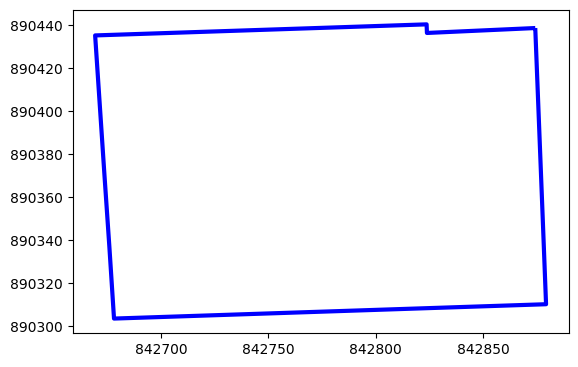

In [81]:
import matplotlib.pyplot as plt

def test_getlotlines_debug():
    # Extract the test parcel with FID = 3641
    test_parcel = parcels_gdf.loc[parcels_gdf['FID'] == 3641].iloc[0]
    print("This is the test parcel: ", test_parcel['geometry'])

    # Call the getlotlines function with the geometry of the extracted parcel
    lot_lines = getlotlines(test_parcel['geometry'])

    # Check if the output is a list of tuples with the expected length
    assert isinstance(lot_lines, list), "Output should be a list"
    assert all(isinstance(item, tuple) and len(item) == 2 for item in lot_lines), "Each item in the list should be a tuple of length 2"

    # Print the coordinates of the parcel
    print("Parcel coordinates:", test_parcel['geometry'].exterior.coords[:])

    # Optionally, visualize the parcel and the generated lot lines
    fig, ax = plt.subplots()
    parcels_gdf[parcels_gdf['FID'] == 3641].plot(ax=ax, edgecolor='blue', linewidth=3, facecolor='none')
    for line, _ in lot_lines:
        x, y = line.xy
        ax.plot(x, y, color='red', linewidth=2)
    plt.show()

# Run the test with additional debugging information
test_getlotlines_debug()

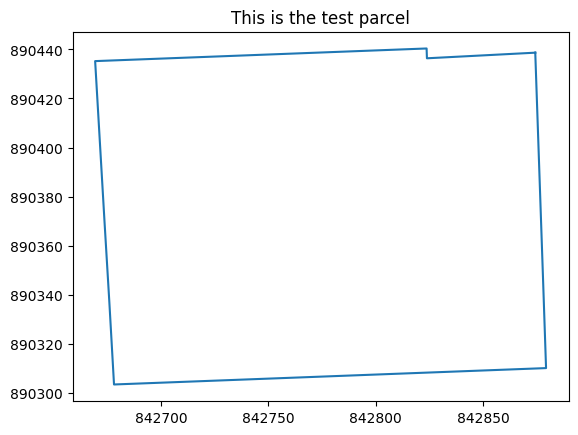

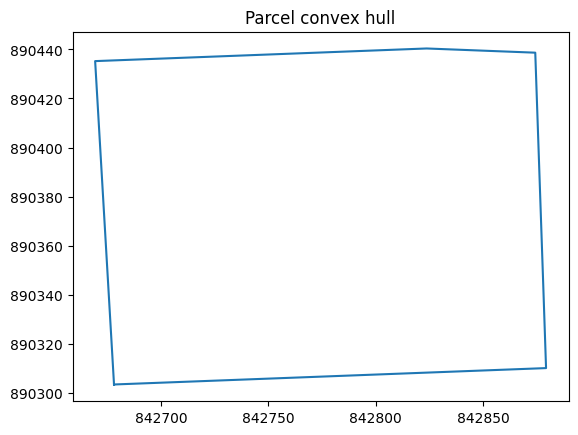

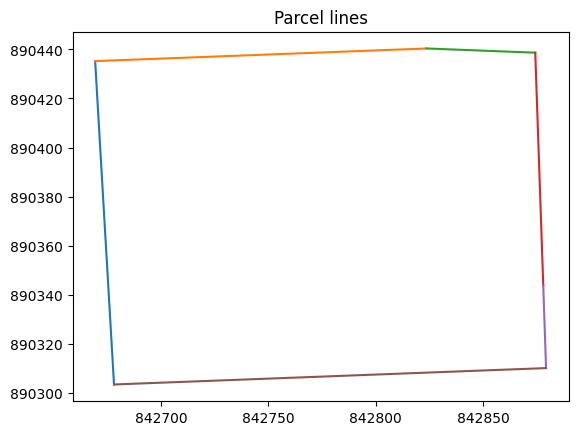

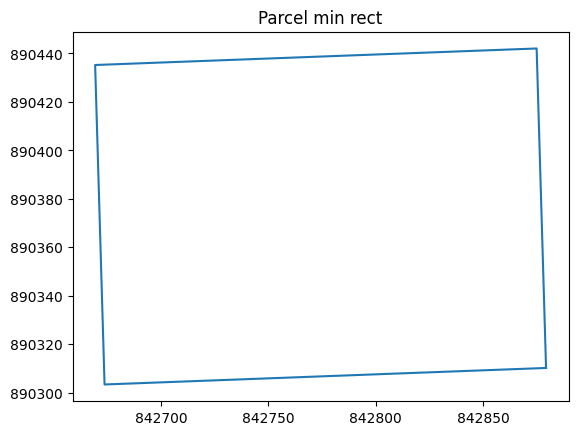

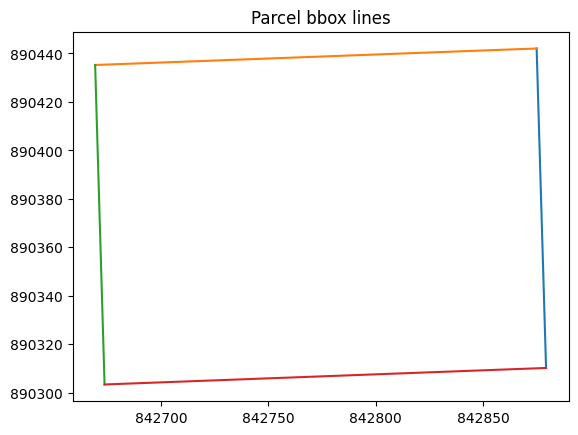

In [79]:
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import LineString

# Read the input data
input_data = [
    ("This is the test parcel", "POLYGON ((842874.1707513975 890438.6573527872, 842877.8899041304 890343.8803115354, 842879.1907545704 890310.1851690027, 842678.2223247701 890303.512281954, 842676.0520534946 890337.0217293022, 842673.79844907 890369.8832121134, 842669.4431427745 890435.2203516654, 842823.6278735725 890440.3666669356, 842823.7820727229 890436.369627704, 842874.1707513975 890438.6573527872))"),
    ("Parcel convex hull", "POLYGON ((842678.2223247701 890303.512281954, 842669.4431427745 890435.2203516654, 842823.6278735725 890440.3666669356, 842874.1707513975 890438.6573527872, 842877.8899041304 890343.8803115354, 842879.1907545704 890310.1851690027, 842678.2223247701 890303.512281954))"),
    ("Parcel lines", ["LINESTRING (842678.222 890303.512, 842669.443 890435.22)", "LINESTRING (842669.443 890435.22, 842823.628 890440.367)", "LINESTRING (842823.628 890440.367, 842874.171 890438.657)", "LINESTRING (842874.171 890438.657, 842877.89 890343.88)", "LINESTRING (842877.89 890343.88, 842879.191 890310.185)", "LINESTRING (842879.191 890310.185, 842678.222 890303.512)"]),
    ("Parcel min rect", "POLYGON ((842879.1907346295 890310.185169488, 842874.8118191119 890442.0661514882, 842669.4422687222 890435.24713152, 842673.8212147239 890303.3661505318, 842879.1907346295 890310.185169488))"),
    ("Parcel bbox lines", ["LINESTRING (842879.191 890310.185, 842874.812 890442.066)", "LINESTRING (842874.812 890442.066, 842669.442 890435.247)", "LINESTRING (842669.442 890435.247, 842673.821 890303.366)", "LINESTRING (842673.821 890303.366, 842879.191 890310.185)"])
]

# Function to plot geometry objects
def plot_geometry(caption, geom):
    if geom.geom_type == "Polygon":
        x, y = geom.exterior.xy
        plt.plot(x, y)
    elif geom.geom_type == "LineString":
        x, y = geom.xy
        plt.plot(x, y)

# Iterate through input data and plot each item
for caption, item in input_data:
    plt.figure()
    if isinstance(item, str):  # Single geometry
        geom = wkt.loads(item)
        plot_geometry(caption, geom)
    elif isinstance(item, list):  # List of geometries
        for geom_str in item:
            geom = wkt.loads(geom_str)
            plot_geometry(caption, geom)
    plt.title(caption)
    plt.show()

# getlotlines visualization

In [71]:
parcel_fid = 3641
selected_parcel = parcels_gdf.loc[parcels_gdf['FID'] == parcel_fid]

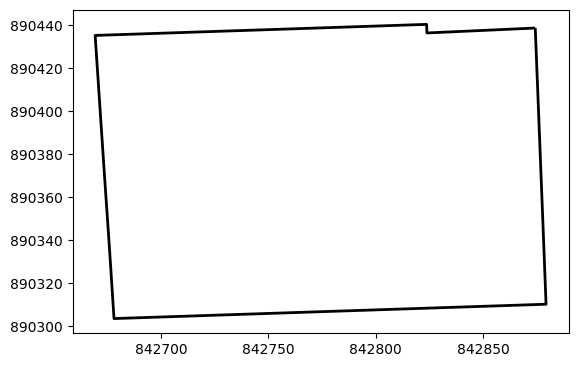

In [73]:
fig, ax = plt.subplots()
selected_parcel.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)
plt.show()


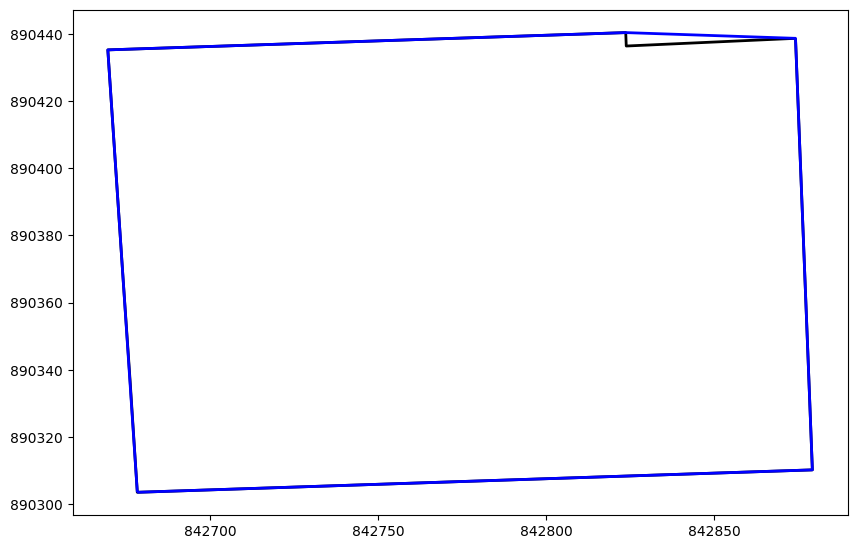

In [74]:
# Calculate the convex hull
convex_hull = selected_parcel.geometry.convex_hull

# Create a new GeoDataFrame with the convex hull
convex_hull_gdf = gpd.GeoDataFrame(geometry=convex_hull)

# Create a new plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original parcel
selected_parcel.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)

# Plot the convex hull
convex_hull_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)

# Show the plot
plt.show()

In [103]:
# Extract the convex hull geometry from the GeoDataFrame
convex_hull_geometry = convex_hull_gdf.geometry.iloc[0]

# Convert the convex hull polygon into a list of linestrings
line_segments = explodeLine(convex_hull_geometry)

# Calculate the rhumb bearings for each line segment using a list comprehension
bearings = [calculate_rhumb_bearing(segment.coords[0], segment.coords[1]) for segment in line_segments]

# Print the bearings
print(bearings)

# Get the number of line segments in the convex hull
num_segments = len(line_segments)

# Print the number of line segments
print("The convex hull has {} line segments.".format(num_segments))

[-0.7012155267708238, 78.27603555586143, 99.9401804494442, 179.57460516831873, 179.58102116071325, -101.66862141804671]
The convex hull has 6 line segments.


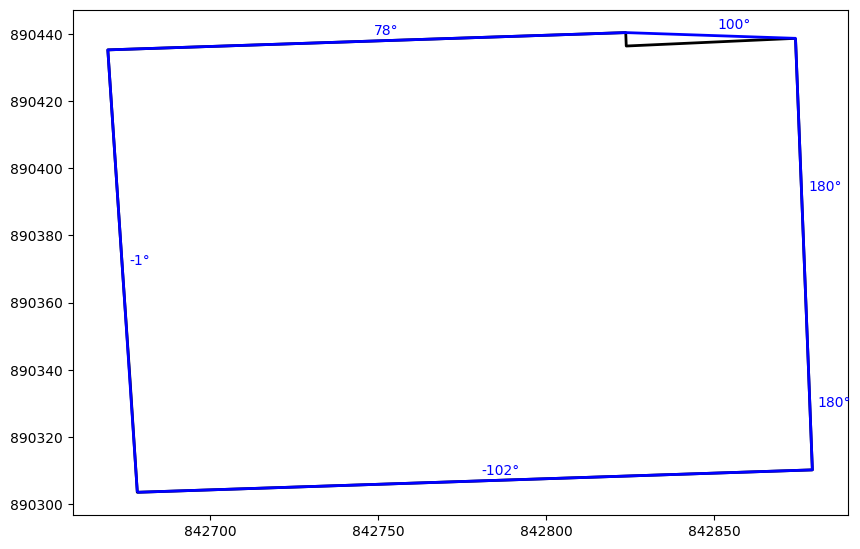

In [105]:
# Create a new plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original parcel
selected_parcel.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)

# Plot the convex hull
convex_hull_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)

# Plot each line segment and label with the bearing
for segment, bearing in zip(line_segments, bearings):
    # Calculate the midpoint of the line segment
    midpoint = segment.interpolate(0.5, normalized=True)
    x, y = midpoint.coords[0]
    
    # Add the bearing label at the midpoint
    plt.annotate("{:.0f}°".format(bearing), xy=(x, y), xytext=(5, 5), textcoords="offset points", color='blue', fontsize=10)

# Show the plot
plt.show()

In [106]:
# Extract the selected parcel geometry from the GeoDataFrame
selected_parcel_geometry = selected_parcel.geometry.iloc[0]

# Calculate the minimum oriented bounding box
min_oriented_bbox = selected_parcel_geometry.minimum_rotated_rectangle

# Convert the bounding box geometry to a GeoDataFrame
bbox_gdf = gpd.GeoDataFrame(geometry=[min_oriented_bbox])

In [107]:
# Extract the bounding box geometry from the GeoDataFrame
bbox_geometry = bbox_gdf.geometry.iloc[0]

# Convert the bounding box polygon into a list of linestrings
bbox_line_segments = explodeLine(bbox_geometry)

# Calculate the rhumb bearings for each line segment using a list comprehension
bbox_bearings = [calculate_rhumb_bearing(segment.coords[0], segment.coords[1]) for segment in bbox_line_segments]

# Print the bearings
print(bbox_bearings)

# Get the number of line segments in the bounding box
num_segments = len(bbox_line_segments)

# Print the number of line segments
print("The bounding box has {} line segments.".format(num_segments))

[-0.3646610264992205, -101.67002035928186, 179.63535041241005, 78.33192288497253]
The bounding box has 4 line segments.


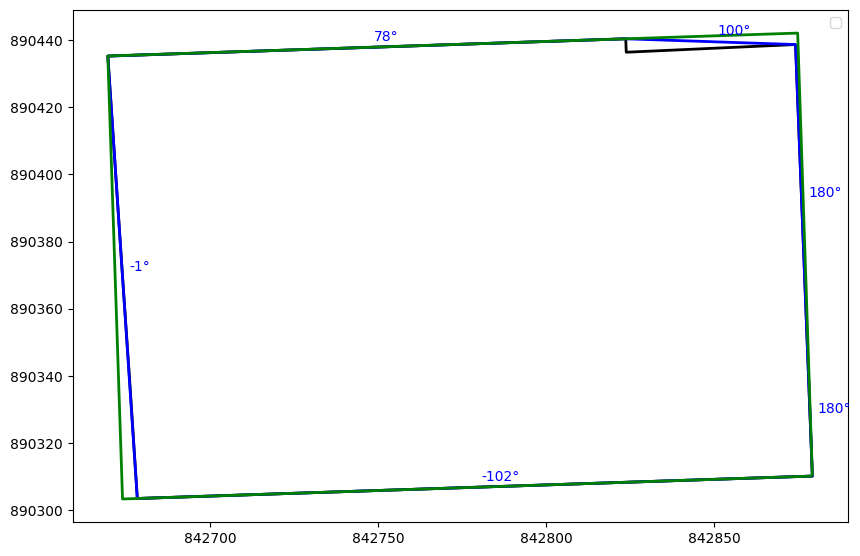

In [108]:
# Create a new plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original parcel
selected_parcel.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)

# Plot the convex hull
convex_hull_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)

# Plot each line segment and label with the bearing
for segment, bearing in zip(line_segments, bearings):
    # Calculate the midpoint of the line segment
    midpoint = segment.interpolate(0.5, normalized=True)
    x, y = midpoint.coords[0]
    
    # Add the bearing label at the midpoint
    plt.annotate("{:.0f}°".format(bearing), xy=(x, y), xytext=(5, 5), textcoords="offset points", color='blue', fontsize=10)

# Plot the bounding box in green
bbox_gdf.plot(ax=ax, edgecolor='green', facecolor='none', linewidth=2)

# Add a legend
ax.legend()

# Show the plot
plt.show()


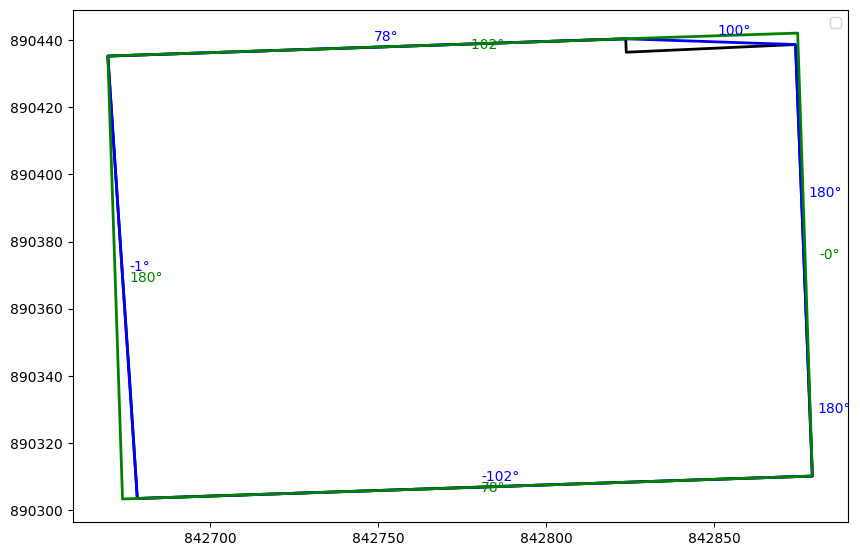

In [112]:
# Create a new plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original parcel
selected_parcel.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)

# Plot the convex hull
convex_hull_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)

# Plot each convex hull line segment and label with the bearing in blue
for segment, bearing in zip(line_segments, bearings):
    # Calculate the midpoint of the line segment
    midpoint = segment.interpolate(0.5, normalized=True)
    x, y = midpoint.coords[0]
    
    # Add the bearing label at the midpoint
    plt.annotate("{:.0f}°".format(bearing), xy=(x, y), xytext=(5, 5), textcoords="offset points", color='blue', fontsize=10)

# Plot each bounding box line segment and label with the bearing in green
offset = 0.02
for i, (segment, bearing) in enumerate(zip(bbox_line_segments, bbox_bearings)):
    # Calculate the midpoint of the line segment
    midpoint = segment.interpolate(0.5, normalized=True)
    x, y = midpoint.coords[0]
    
    # Add the bearing label at the midpoint with an offset
    label_y = y - offset * (i + 1)
    plt.annotate("{:.0f}°".format(bearing), xy=(x, y), color='green',
             xytext=(10, 0), textcoords="offset points", fontsize=10,
             ha="left", va="center", xycoords="data")

# Plot the bounding box in green
bbox_gdf.plot(ax=ax, edgecolor='green', facecolor='none', linewidth=2)

# Add a legend
ax.legend()

# Show the plot
plt.show()

# Initial Exploration

In [ ]:
# Create the minimum bounding rectangle for the parcel polygon
mbr_poly = parcel_poly.minimum_rotated_rectangle


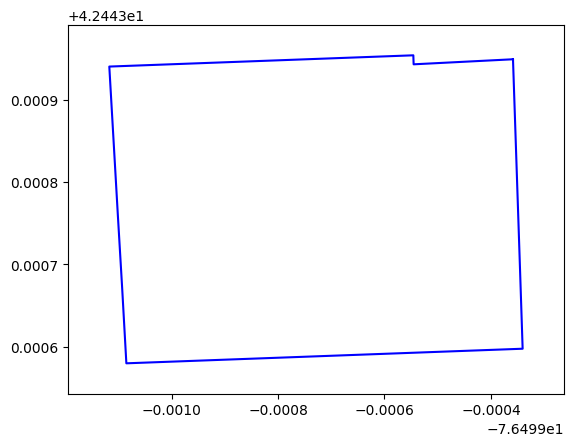

In [ ]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the parcel polygon and minimum bounding rectangle on the same plot
ax.plot(*parcel_poly.exterior.xy, color='blue')
#ax.plot(*mbr_poly.exterior.xy, color='red')

x,y = parcel_poly.exterior.xy

# Set the x and y limits for the plot
padding_percent = 0.1
x_range = max(x) - min(x)
y_range = max(y) - min(y)
ax.set_xlim(min(x) - padding_percent * x_range, max(x) + padding_percent * x_range)
ax.set_ylim(min(y) - padding_percent * y_range, max(y) + padding_percent * y_range)

# Show the plot
plt.show()

In [ ]:
# Simplify the polygon with a tolerance of 0.000001 units
simplified_poly = parcel_poly.simplify(0.000001, preserve_topology=True)

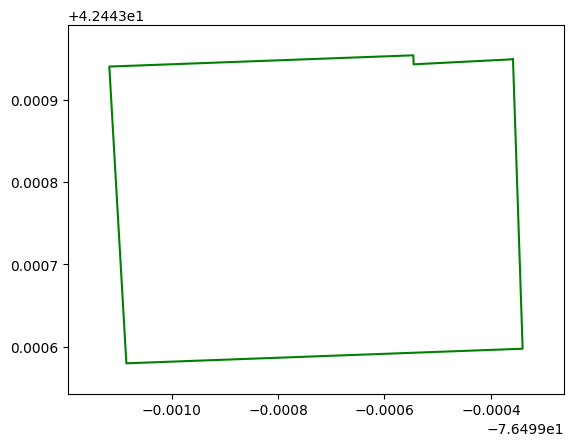

In [ ]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the simplified parcel polygon
ax.plot(*simplified_poly.exterior.xy, color='green')

x,y = parcel_poly.exterior.xy

# Set the x and y limits for the plot
padding_percent = 0.1
x_range = max(x) - min(x)
y_range = max(y) - min(y)
ax.set_xlim(min(x) - padding_percent * x_range, max(x) + padding_percent * x_range)
ax.set_ylim(min(y) - padding_percent * y_range, max(y) + padding_percent * y_range)

# Show the plot
plt.show()

In [ ]:
parcel_lines = explodeLine(simplified_poly)
print(len(parcel_lines))
print(parcel_lines)

6
[<LINESTRING (-76.499 42.444, -76.499 42.444)>, <LINESTRING (-76.499 42.444, -76.5 42.444)>, <LINESTRING (-76.5 42.444, -76.5 42.444)>, <LINESTRING (-76.5 42.444, -76.5 42.444)>, <LINESTRING (-76.5 42.444, -76.5 42.444)>, <LINESTRING (-76.5 42.444, -76.499 42.444)>]


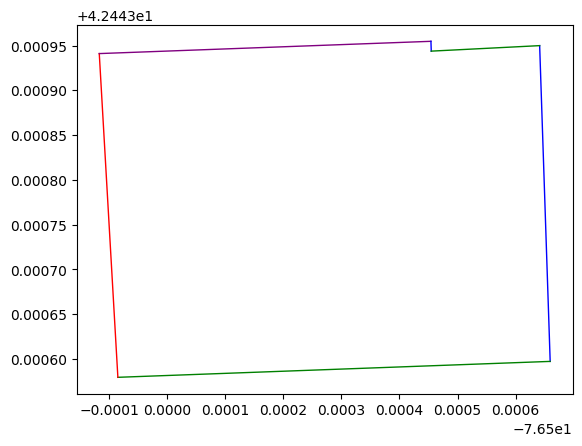

In [ ]:
fig, ax = plt.subplots()
colors = ['blue', 'green', 'red', 'purple']  # Add colors for each line

for i, line in enumerate(parcel_lines):  # Use enumerate to get the index of each line
  x, y = line.xy
  ax.plot(x, y, color=colors[i % len(colors)], linewidth=1)  # Use modulus operator to cycle through colors list

plt.show()

In [ ]:
roads_gdf = gpd.read_file("/content/drive/MyDrive/Cornell/Exit Project/TcStreets.geojson")

In [ ]:
# Assume 'roads_gdf' is your GeoDataFrame containing the road network
road_geoms = []
for geom in roads_gdf.geometry:
    if isinstance(geom, LineString):
        road_geoms.append(LineString(geom.coords))
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:
            road_geoms.append(LineString(line.coords))

# Create the STRtree index
tree = STRtree(road_geoms)

In [ ]:
print(len(tree))

# do i need to split at each intersection? this seems low...

In [ ]:
# Assume 'parcel_poly' is your polygon of interest
centroid = parcel_poly.centroid

# Use the STRtree to find the index of the nearest road segment to the centroid
nearest_index = tree.query(centroid)[0]

# Look up the corresponding geometry in the 'road_geoms' list
nearest_segment = road_geoms[nearest_index]

# Get the index of the nearest segment in the 'road_geoms' list
nearest_segment_index = road_geoms.index(nearest_segment)

# Calculate the distance between the centroid and the nearest segment
distance = nearest_segment.distance(centroid)

# Print the nearest segment index and its distance from the centroid
print(f"The nearest road segment has index {nearest_segment_index}, which is {distance:.5f} units away from the centroid.")

The nearest road segment has index 2160, which is 0.00050 units away from the centroid.
